## Code for Stucture Evaluation for _Automatic hierarchy expansion for improved structure and chord evaluation_ 

In this notebook, we detail the method and experiments for the automatic hierarchy expansion applied to two sets of structure annotations for Beatles music. The first is from the Isophonics data set and and the second is the Beatles-
TuT data.  

A few notes: 
* Paths are hard coded, and as such, you will need to update these on your own machine for this notebook to run
* These methods are written to work on `.jams` files

#### Utility Functions

This first section includes utility functions as well as the packages that are needed for this notebook

In [1]:
import jams
import numpy as np
import matplotlib.pyplot as plt
import jams.display
import mir_eval
import mir_eval.display
import pandas as pd
from joblib import Parallel, delayed
%matplotlib inline

In [2]:
from collections import Counter
from copy import deepcopy
import os
from tqdm import tqdm as tqdm
import itertools
import seaborn as sns

In [3]:
def issame(labs1, labs2):
    
    # Hash the strings
    h1 = [hash(_) for _ in labs1]
    h2 = [hash(_) for _ in labs2]
    
    # Build the segment label agreement matrix
    a1 = np.equal.outer(h1, h1)
    a2 = np.equal.outer(h2, h2)
    
    # Labelings are the same if the segment label agreements are identical
    return np.all(a1 == a2)

### Functions coalescing structure labels

In the below function, we describe a list of string substitution rules for the Isophonics and TUT annotations that have the goal of grouping similar labels. This substitutions are necessary before applying the automatic hierarchy expansion to an annotation. 

In [4]:
def flatten_labels(_labels, anno_type):
    
    # Are there other rules for segment coalescing?
    # VerseA, VerseB -> Verse
    # verse_(guitar solo) ...
    # _(.*)
    # /.*
    
    labels = []
    
    if anno_type == 'TUT' or anno_type == 'T':
        # making the labels for TUT files
        for y in _labels:
            # lower the case in x
            x = y.lower()
            
            # There are 16 cases. We will take each case separately:
            if "break" in x:
                labels.append("break ")
            elif "bridge" in x:
                labels.append("bridge ")
            elif "clos" in x:
                labels.append("clos ")
                
            elif "guitars" in x:
                labels.append("solo ")
            elif "impro" in x:
                labels.append("improv ")
            elif "interlude" in x:
                labels.append("interlude ")
                
            elif "intro" in x:
                labels.append("intro ")
            elif "connector" in x:
                labels.append("connector ")
            elif "mr" in x:
                labels.append("MR ")
                
            elif "out" in x:
                labels.append("out ")
            elif "refrain" in x:
                labels.append("refrain ")
            elif "solo" in x:
                labels.append("solo ")
                
            elif "verse" in x:
                labels.append("verse ")
            elif "ver" in x:
                labels.append("verse ")
            elif "si" in x:
                labels.append("silence ")
                
            else:
                labels.append(x + " ")
    
    elif anno_type == 'Iso' or anno_type == 'I':
        # making the labels for Isophonics
        for x in _labels:
            # one special case "part_"
            if x[:5] == "part_":
                lst_x = x.split("_")
                labels.append(lst_x[0] + "_" + lst_x[1] + " ")
                
            # Now for a few basic cases
            
            elif "verse" in x:
                labels.append("verse ")
                
            elif "intro" in x:
                labels.append("intro ")
                
            elif "refrain" in x:
                labels.append("refrain ")
                
            elif "solo" in x:
                labels.append("solo ")
                
            elif "bridge" in x:
                labels.append("bridge ")
            
            elif "connector" in x:
                labels.append("connector ")
                
            elif "outro" in x:
                labels.append("outro ")
                
            # major cases including {',_,-,/} 
            # drop the {',_,-,/} and all that follows
            elif "'" in x:
                lst_x = x.split("'")
                labels.append(lst_x[0] + " ")
            
            elif "_" in x:
                lst_x = x.split("_")
                labels.append(lst_x[0] + " ")
            
            elif "-" in x:
                lst_x = x.split("-")
                labels.append(lst_x[0] + " ")
            
            elif "/" in x:
                lst_x = x.split("/")
                labels.append(lst_x[0] + " ")
                
            elif "/" in x:
                lst_x = x.split("/")
                labels.append(lst_x[0] + " ")
                
            else:
                labels.append(x + " ")

    else:
        print("Declare the kind of annotations.")
        return None
    
    
    return labels

Now we check that the above function coalesces labels as we expect: 

In [5]:
tut_labels = list(line.strip() for line in open('tut_labs.txt', 'r'))
tut_simp = flatten_labels(tut_labels, 'T')
list(zip(tut_labels, tut_simp))

FileNotFoundError: [Errno 2] No such file or directory: 'tut_labs.txt'

In [ ]:
iso_labels = list(line.strip() for line in open('iso_labs.txt', 'r'))
iso_simp = flatten_labels(iso_labels, 'I')
list(zip(iso_labels, iso_simp))

## Creating Hierarchies

The next series of functions create the hierarchies as described in the paper. 

In [5]:
def expand_labels(labels, anno_type):
    """EXPAND_LABELS creates the refined level of the automatic hierarchy. This function  
    begins by coalesces the original annotations into groups of labels. Then each instance
    of a group is labeled using a number of single quotes, such that the first instance 
    has no quotes, the second has one single quote, the third has two, and so on. """
    
    flat = flatten_labels(labels, anno_type)

    seg_counter = Counter()
    
    expanded = []
    for label in flat:
        expanded.append(' {}{}'.format(label[:-1], "'" * seg_counter[label]))
        seg_counter[label] += 1
        
    return expanded


def expand_hierarchy(_ann, anno_type, full=False):
    """EXPAND_HIERARCHY creates the automatic hierarchy expansion for structure 
    annotations for Beatles files in the Isophonics and Beatles-TUT datasets. 
    Beginning by creating the contraction level using FLATTEN_LABELS and then 
    creating the refinement level using EXPAND_LABELS. Levels are only included
    if they are differen than the original annotation."""
    
    # Make a copy
    ann = deepcopy(_ann)
    
    # Flatten the annotation
    h_intervals, h_labels = jams.eval.hierarchy_flatten(ann)
    
    # Remove the old segment data
    ann.pop_data()
    
    level = 0
    for ints, labs in zip(h_intervals, h_labels):
        
        # Push the flattened segments
        lab_flat = flatten_labels(labs, anno_type)
        
        # Only add this one if lab_flat agreements != lab agreements
        if full or not issame(lab_flat, labs):
            for ival, label in zip(ints, lab_flat):
                ann.append(time=ival[0], duration=ival[1]-ival[0], value=dict(label=label, level=level))
            level += 1
        
        # Push the original segments
        for ival, label in zip(ints, labs):
            ann.append(time=ival[0], duration=ival[1]-ival[0], value=dict(label=label, level=level))
        level += 1
        
        # Push the expanded segments
        lab_exp = expand_labels(labs, anno_type)
        
        # Only add this one if lab_exp agreements != lab agreements
        if full or not issame(lab_exp, labs):
            for ival, label in zip(ints, lab_exp):
                ann.append(time=ival[0], duration=ival[1]-ival[0], value=dict(label=label, level=level))
            level += 1

    # TODO:
    #  fix annotation metadata
    return ann

In [6]:
def flat_to_hier(ann):
    """Takes a flat annotation and creates a hierarchy (of one level). 
    This is effectively a 'type' change, resulting in an annotation with 
    the multi-segment designation."""
    
    # Create object to place the annotations into
    ann_h = jams.Annotation('multi_segment',
                            time=ann.time,
                            duration=ann.duration)
    
    for obs in ann:
        # Original string 
        ann_h.append(time=obs.time, duration=obs.duration,
                    value=dict(level=0, label=obs.value),
                    confidence=obs.confidence)
    return ann_h



#### Testing above functions on a particular song

In this next section, we are testing the above functions on one song. After creating the flatten labels (using `flat_to_hier`) and then creating the automatic hierarchy expansion, we check that both carry the `multi_segment` designation as well as look at the created object. We then move to creating visualizations that compare the flat hierarchy to itself as well as the expanded on to itself. The comparisons are conducted using methods inside `mir_eval`.

In [7]:
dirName = "/Users/kkinnaird/Documents/Research/R-Music/Brian-AHE/jams-data/datasets/"

fname = dirName + "BeatlesTUT/01_-_A_Hard_Day's_Night.jams"
J = jams.load(fname)

a1 = J.annotations["segment",0]

In [8]:
# convert to an hierarchy object first 
a1_h = flat_to_hier(a1)

# Apply expansion
exp_a1 = expand_hierarchy(a1_h, "TUT", full=True)

In [9]:
# Investigate the un-expanded hierarchy object
a1_h

<Annotation(namespace='multi_segment',
            time=0,
            duration=None,
            annotation_metadata=<AnnotationMetadata(...)>,
            data=<12 observations>,
            sandbox=<Sandbox(...)>)>

In [10]:
# Investigate the expanded hierarchy
exp_a1

<Annotation(namespace='multi_segment',
            time=0,
            duration=None,
            annotation_metadata=<AnnotationMetadata(...)>,
            data=<36 observations>,
            sandbox=<Sandbox(...)>)>

In [11]:
# Prepare the flat hierarchy for evaluation metrics
h_ints, h_labs = jams.eval.hierarchy_flatten(a1_h)

In [12]:
flat_meet = mir_eval.hierarchy._meet(h_ints, h_labs, 0.1)

In [13]:
# Prepare the expanded hierarchy for evaluation metrics
h_ints, h_labs = jams.eval.hierarchy_flatten(exp_a1)

In [14]:
exp_meet = mir_eval.hierarchy._meet(h_ints, h_labs, 0.1)

#### Create images of the self-comparisons

The below block creates two self-similarity matrices. The first shows where the flat annotations agree and the second shows where (and how deeply) the automatic expanded hierarchy meets. 

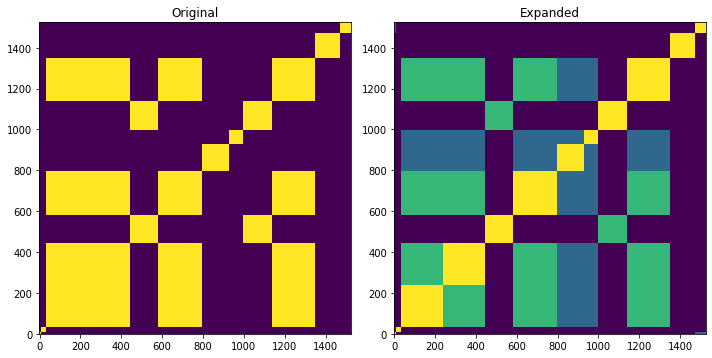

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(flat_meet.todense(), aspect='equal', origin='lower')
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(exp_meet.todense(), aspect='equal', origin='lower')
plt.title('Expanded')
plt.tight_layout()

Now we check that various measures comparing the flat and automatic hierarchy versions of the annotation. This is followed by a cell exploring the expanded hierarchy visually leveraging built in features from the `jams` package. 

In [16]:
jams.eval.hierarchy(a1_h, exp_a1)

OrderedDict([('T-Precision reduced', 0.0),
             ('T-Recall reduced', 1.0),
             ('T-Measure reduced', 0.0),
             ('T-Precision full', 1.0),
             ('T-Recall full', 1.0),
             ('T-Measure full', 1.0),
             ('L-Precision', 0.726507238425894),
             ('L-Recall', 1.0),
             ('L-Measure', 0.8415918824508045)])

In [17]:
exp_a1


<Annotation(namespace='multi_segment',
            time=0,
            duration=None,
            annotation_metadata=<AnnotationMetadata(...)>,
            data=<36 observations>,
            sandbox=<Sandbox(...)>)>

---
# 1. L-measure with and without expansion

In this section, we compare the L-measure between the TuT and Isophonics annotations with and without the hierarchical expansions. We begin this section similar to the above one with a section defining a few functions.

##### Importing the data

Before continuing, we read in the data lists created in the `Matching-TUT-Iso.ipynb` notebook. These files list the Beatles tracks that appear in both datasets in the same order. We then spot check that our lists match in the next two cells. 

In [19]:
save_dir = "/Users/kkinnaird/Documents/Research/R-Music/Brian-AHE/tismir2020-hierarchy/" 
tut_file = save_dir + "tut_file_list.csv"
print(tut_file)
tut_pd = pd.read_csv(tut_file, delimiter=",", header = None)

/Users/kkinnaird/Documents/Research/R-Music/Brian-AHE/tismir2020-hierarchy/tut_file_list.csv


ParserError: Error tokenizing data. C error: Expected 1 fields in line 34, saw 4


In [20]:
# read the TUT and Isophonic files

save_dir = "/Users/kkinnaird/Documents/Research/R-Music/Brian-AHE/tismir2020-hierarchy/" 

# read in the TUT files:
tut_file = save_dir + "tut_file_list.csv"
tut_pd = pd.read_csv(tut_file, delimiter=",", header = None)
Tjamses = tut_pd[0].values.tolist()

# read in the Iso files:
iso_file = save_dir + "iso_file_list.csv"
iso_pd = pd.read_csv(iso_file, delimiter=",", header = None)
Ijamses = iso_pd[0].values.tolist()

In [21]:
Tjamses

['05_-_Little_Child.jams',
 '11_-_I_Wanna_Be_Your_Man.jams',
 '07_-_Please_Mister_Postman.jams',
 "02_-_All_I've_Got_To_Do.jams",
 '08_-_Roll_Over_Beethoven.jams',
 "04_-_Don't_Bother_Me.jams",
 '12_-_Devil_In_Her_Heart.jams',
 '09_-_Hold_Me_Tight.jams',
 '14_-_Money.jams',
 '13_-_Not_A_Second_Time.jams',
 '03_-_All_My_Loving.jams',
 "01_-_It_Won't_Be_Long.jams",
 '10_-_You_Really_Got_A_Hold_On_Me.jams',
 '06_-_Till_There_Was_You.jams',
 '04_-_I_Me_Mine.jams',
 '03_-_Across_the_Universe.jams',
 '10_-_The_Long_and_Winding_Road.jams',
 '11_-_For_You_Blue.jams',
 '06_-_Let_It_Be.jams',
 '12_-_Get_Back.jams',
 '09_-_One_After_909.jams',
 '02_-_Dig_a_Pony.jams',
 '05_-_Dig_It.jams',
 '01_-_Two_of_Us.jams',
 '07_-_Maggie_Mae.jams',
 "08_-_I've_Got_A_Feeling.jams",
 "14_-_Everybody's_Trying_to_Be_My_Baby.jams",
 "05_-_I'll_Follow_the_Sun.jams",
 '09_-_Words_of_Love.jams',
 '06_-_Mr._Moonlight.jams',
 "10_-_Honey_Don't.jams",
 '01_-_No_Reply.jams',
 "03_-_Baby's_In_Black.jams",
 '07_-_Kansas_C

In [22]:
Ijamses

['02_-_With_the_Beatles/05_-_Little_Child.jams',
 '02_-_With_the_Beatles/11_-_I_Wanna_Be_Your_Man.jams',
 '02_-_With_the_Beatles/07_-_Please_Mister_Postman.jams',
 "02_-_With_the_Beatles/02_-_All_I've_Got_To_Do.jams",
 '02_-_With_the_Beatles/08_-_Roll_Over_Beethoven.jams',
 "02_-_With_the_Beatles/04_-_Don't_Bother_Me.jams",
 '02_-_With_the_Beatles/12_-_Devil_In_Her_Heart.jams',
 '02_-_With_the_Beatles/09_-_Hold_Me_Tight.jams',
 '02_-_With_the_Beatles/14_-_Money.jams',
 '02_-_With_the_Beatles/13_-_Not_A_Second_Time.jams',
 '02_-_With_the_Beatles/03_-_All_My_Loving.jams',
 "02_-_With_the_Beatles/01_-_It_Won't_Be_Long.jams",
 '02_-_With_the_Beatles/10_-_You_Really_Got_A_Hold_On_Me.jams',
 '02_-_With_the_Beatles/06_-_Till_There_Was_You.jams',
 '12_-_Let_It_Be/04_-_I_Me_Mine.jams',
 '12_-_Let_It_Be/03_-_Across_the_Universe.jams',
 '12_-_Let_It_Be/10_-_The_Long_and_Winding_Road.jams',
 '12_-_Let_It_Be/11_-_For_You_Blue.jams',
 '12_-_Let_It_Be/06_-_Let_It_Be.jams',
 '12_-_Let_It_Be/12_-_Get_B

### Defining comparison functions

We extend the original `compare_hierarchies` function for structure to be applied to comparisons of the Isophonics and TuT annotations of the Beatles songs. As with the original one, the `compare_hierarchies` function compares the L-measures for the flat annotation to the L-measures for the expanded hierarchy. 

We note that this function declares the TuT annotation as the _reference_ and the Isophonics as the _estimate._

In [23]:
FRAME_SIZE = 0.1

def compare_hierarchies(_tut_jam, _iso_jam):
    
    dirName = "/Users/kkinnaird/Documents/Research/R-Music/Brian-AHE/jams-data/datasets/"
    tut_jam = dirName + "BeatlesTUT/" + _tut_jam
    iso_jam = dirName + "Isophonics/The Beatles/" + _iso_jam
    
    T = jams.load(tut_jam, validate=False)
    I = jams.load(iso_jam, validate=False)
    
    if (len(T.annotations['segment']) < 1) and (len(I.annotations['segment']) < 1):
        return
    
    data = []
    index = []
    
    a1 = T.annotations["segment",0]
    a1_h = flat_to_hier(a1)
    
    a2 = I.annotations["segment",0]
    a2_h = flat_to_hier(a2)
    
    
    # Original metric
    losses = jams.eval.hierarchy(a1_h, a2_h, frame_size=FRAME_SIZE)
    
    # Expanded metric
    e1 = expand_hierarchy(a1_h,"T")
    e2 = expand_hierarchy(a2_h,"I")
    
    losses_exp = jams.eval.hierarchy(e1, e2, frame_size=FRAME_SIZE)
    
    losses.update({'Expanded {}'.format(_): losses_exp[_] for _ in losses_exp})
    
    losses = {_: losses[_] for _ in losses if 'T-' not in _}
    losses['ref_name'] = "TUT"
    losses['est_name'] = "Isophonics"
        
    data.append(losses)
    index.append(jams.util.filebase(iso_jam))
    
    return pd.DataFrame(data, index=index)

### Experiments on Structure Annotations

Using the above function, we compare the L-measures for the original and expanded annotations. We explore the results with both visual and numerical summaries of the data frame resulting from the above functions. 

In [24]:
orig_vs_expanded = pd.concat(Parallel(n_jobs=20)(delayed(compare_hierarchies)(a,b)
                                                  for a,b in tqdm(zip(Tjamses, Ijamses))))

81it [01:10,  1.05s/it]//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
174it [03:35,  1.20s/it]


In [25]:
# Saving the results

orig_vs_expanded.to_csv('/Users/kkinnaird/Documents/Research/R-Music/Brian-AHE/orig_vs_expanded.csv')

In [26]:
sns.set_style('whitegrid')

Text(0.5, 1.0, 'Flat Annotations vs Expanded Hierarchy')

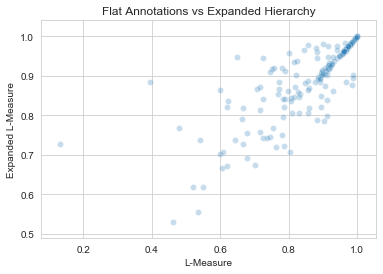

In [27]:
sns.scatterplot(data=orig_vs_expanded, x='L-Measure', y='Expanded L-Measure', alpha=0.25)
plt.title("Flat Annotations vs Expanded Hierarchy")

AttributeError: 'AxesSubplot' object has no attribute 'axline'

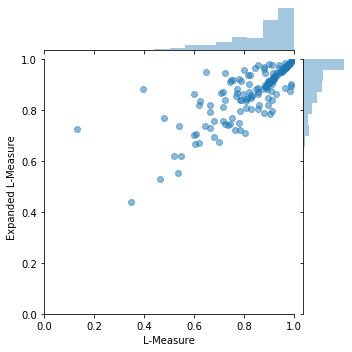

In [5]:
df = pd.read_csv('orig_vs_expanded.csv', index_col=0)

jp = sns.jointplot('L-Measure', 'Expanded L-Measure', data=df, alpha=0.5,xlim=[0, 1], ylim=[0, 1], height=5)
jp.ax_joint.axline((0, 0), slope=1, linewidth=1, alpha=0.5, color='k')
plt.savefig('isotut-expansion.svg', format='svg', transparent=True)

In [30]:
df = pd.read_csv('../orig_vs_expanded.csv', index_col=0)
df.describe()

,Expanded L-Measure,Expanded L-Precision,Expanded L-Recall,L-Measure,L-Precision,L-Recall
count,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000
mean,0.888079,0.890474,0.887499,0.853167,0.859058,0.850144
std,0.096356,0.101553,0.097264,0.139981,0.144656,0.133362
min,0.530112,0.513216,0.548158,0.131443,0.081931,0.332200
25%,0.840739,0.836606,0.852782,0.784957,0.794586,0.764920
50%,0.913059,0.916617,0.916360,0.898042,0.904926,0.895243
75%,0.964929,0.974106,0.960766,0.962331,0.972837,0.954499
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Seeking Extremal Examples

In this final section of the notebook, we seek examples of both extreme improvement in our structure annotations as well as extreme deterioration. We then visualize this examples' annotations. 

In [31]:
(-(orig_vs_expanded['L-Measure'] - orig_vs_expanded['Expanded L-Measure'])).describe()

count    174.000000
mean       0.034913
std        0.089031
min       -0.117748
25%        0.000123
50%        0.005409
75%        0.059757
max        0.595304
dtype: float64

In [32]:
# Which one has the biggest drop when expanding?
(orig_vs_expanded['L-Measure'] - orig_vs_expanded['Expanded L-Measure']).argmax()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  


'07_-_Michelle'

In [33]:
(orig_vs_expanded['L-Measure'] - orig_vs_expanded['Expanded L-Measure'])

05_-_Little_Child                                                      -0.001124
11_-_I_Wanna_Be_Your_Man                                               -0.001409
07_-_Please_Mister_Postman                                             -0.051374
02_-_All_I've_Got_To_Do                                                -0.094348
08_-_Roll_Over_Beethoven                                               -0.101927
04_-_Don't_Bother_Me                                                   -0.012060
12_-_Devil_In_Her_Heart                                                -0.075733
09_-_Hold_Me_Tight                                                     -0.031530
14_-_Money                                                             -0.070665
13_-_Not_A_Second_Time                                                 -0.014336
03_-_All_My_Loving                                                     -0.003135
01_-_It_Won't_Be_Long                                                  -0.062014
10_-_You_Really_Got_A_Hold_O

In [34]:
# Which one has the biggest increase when expanding?
(orig_vs_expanded['Expanded L-Measure'] - orig_vs_expanded['L-Measure']).argmax()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  


'05_-_Dig_It'

In [35]:
# Which one has the biggest increase when expanding?
(orig_vs_expanded['Expanded L-Measure'] - orig_vs_expanded['L-Measure']).argmin()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  


'07_-_Michelle'

In [36]:
exp_minus_orig = (orig_vs_expanded['Expanded L-Measure'] - orig_vs_expanded['L-Measure'])

In [37]:
exp_minus_orig.sort_values(ascending=False).head(10)

05_-_Dig_It                                  0.595304
CD1_-_15_-_Why_Don't_We_Do_It_In_The_Road    0.487439
04_-_I_Me_Mine                               0.299110
07_-_Kansas_City-_Hey,_Hey,_Hey,_Hey         0.288553
09_-_I'll_Cry_Instead                        0.266411
08_-_Eight_Days_a_Week                       0.218793
10_-_I'm_Looking_Through_You                 0.212173
14_-_Dizzy_Miss_Lizzy                        0.200596
10_-_The_Long_and_Winding_Road               0.196933
04_-_Oh!_Darling                             0.166198
dtype: float64

In [38]:
exp_minus_orig.sort_values(ascending=False).tail(10)

08_-_Love_Me_Do                             -0.073946
02_-_I'm_a_Loser                            -0.075424
09_-_Penny_Lane                             -0.081060
14_-_Tomorrow_Never_Knows                   -0.085883
06_-_Ask_Me_Why                             -0.093675
02_-_Norwegian_Wood_(This_Bird_Has_Flown)   -0.094700
CD2_-_02_-_Yer_Blues                        -0.096915
03_-_You've_Got_To_Hide_Your_Love_Away      -0.110175
07_-_Maggie_Mae                             -0.113446
07_-_Michelle                               -0.117748
dtype: float64

In [39]:
orig_vs_expanded.loc['05_-_Dig_It']

Expanded L-Measure        0.726748
Expanded L-Precision      0.740883
Expanded L-Recall         0.713142
L-Measure                 0.131443
L-Precision              0.0819306
L-Recall                    0.3322
est_name                Isophonics
ref_name                       TUT
Name: 05_-_Dig_It, dtype: object

In [40]:
orig_vs_expanded.loc["CD1_-_15_-_Why_Don't_We_Do_It_In_The_Road"]

Expanded L-Measure          0.8832
Expanded L-Precision       0.81733
Expanded L-Recall         0.960618
L-Measure                 0.395761
L-Precision               0.297452
L-Recall                  0.591136
est_name                Isophonics
ref_name                       TUT
Name: CD1_-_15_-_Why_Don't_We_Do_It_In_The_Road, dtype: object

In [41]:
orig_vs_expanded.loc["03_-_You've_Got_To_Hide_Your_Love_Away"]

Expanded L-Measure         0.87569
Expanded L-Precision      0.836053
Expanded L-Recall         0.919273
L-Measure                 0.985865
L-Precision               0.985777
L-Recall                  0.985953
est_name                Isophonics
ref_name                       TUT
Name: 03_-_You've_Got_To_Hide_Your_Love_Away, dtype: object

In [42]:
orig_vs_expanded.loc["CD1_-_02_-_Dear_Prudence"]

Expanded L-Measure        0.966905
Expanded L-Precision      0.966476
Expanded L-Recall         0.967333
L-Measure                 0.967069
L-Precision               0.966751
L-Recall                  0.967388
est_name                Isophonics
ref_name                       TUT
Name: CD1_-_02_-_Dear_Prudence, dtype: object

In [43]:
orig_vs_expanded.loc["07_-_Michelle"]

Expanded L-Measure        0.785731
Expanded L-Precision      0.722027
Expanded L-Recall         0.861764
L-Measure                 0.903479
L-Precision               0.928144
L-Recall                  0.880092
est_name                Isophonics
ref_name                       TUT
Name: 07_-_Michelle, dtype: object

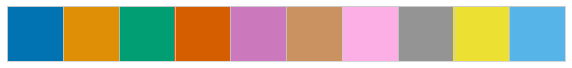

In [44]:
current_palette = sns.color_palette('colorblind')
sns.palplot(current_palette)
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

In [45]:
dirName = "/Users/kkinnaird/Documents/Research/R-Music/Brian-AHE/jams-data/datasets/"
fname = '05_-_Dig_It.jams'
tut_jam = dirName + "BeatlesTUT/" + fname

inds = Tjamses.index(fname)
iso_jam = dirName + "Isophonics/The Beatles/" + Ijamses[inds]

T = jams.load(tut_jam)
I = jams.load(iso_jam)

(<Figure size 576x576 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x1c1cff7c50>])

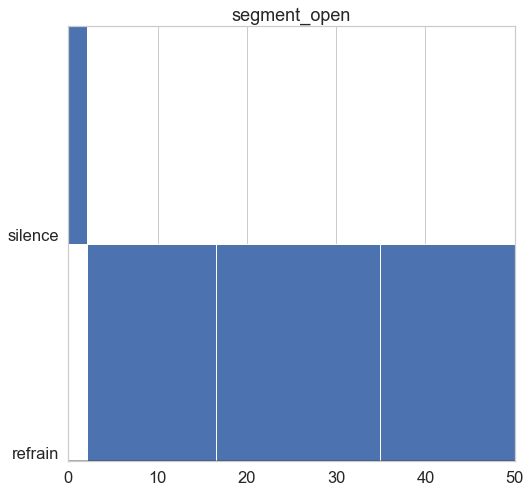

In [46]:
jams.display.display_multi(T.annotations['segment'], meta=False,
                           fig_kw=dict(figsize=(8,8)))

(<Figure size 576x576 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x1c1d173780>])

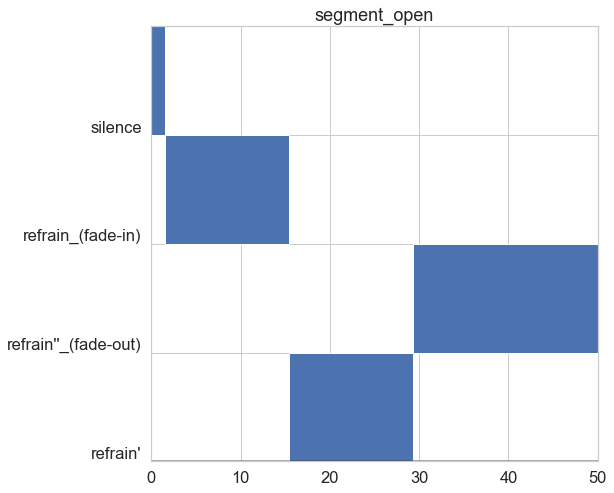

In [47]:
jams.display.display_multi(I.annotations['segment'], meta=False,
                           fig_kw=dict(figsize=(8,8)))

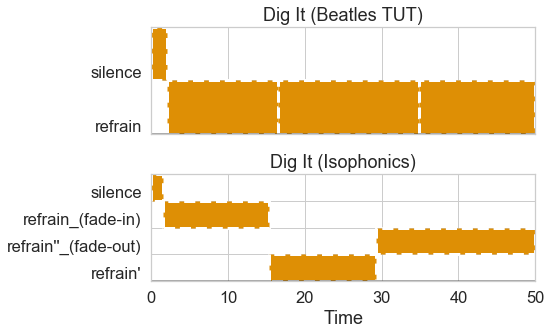

In [48]:
fig, (ax1, ax2) = plt.subplots(figsize=(8, 5), sharex=True, nrows=2)
jams.display.display(T.annotations['segment',0], meta=False, linewidth=3, facecolor=current_palette[1], linestyle='--', ax=ax1)
ax1.set(title='Dig It (Beatles TUT)')
ax1.label_outer()
jams.display.display(I.annotations['segment',0], meta=False, linewidth=3, facecolor=current_palette[1], linestyle='--', ax=ax2)
ax2.set(xlabel='Time', title='Dig It (Isophonics)')
plt.tight_layout();
fig.savefig('digit.pdf', format='pdf', transparent=True, pad_inches=0.1)

In [49]:
T_h = flat_to_hier(T.annotations['segment',0])

exp_T = expand_hierarchy(T_h, "TUT")


I_h = flat_to_hier(I.annotations['segment',0])

exp_I = expand_hierarchy(I_h, "I")

In [50]:
exp_T

<Annotation(namespace='multi_segment',
            time=0,
            duration=None,
            annotation_metadata=<AnnotationMetadata(...)>,
            data=<10 observations>,
            sandbox=<Sandbox(...)>)>

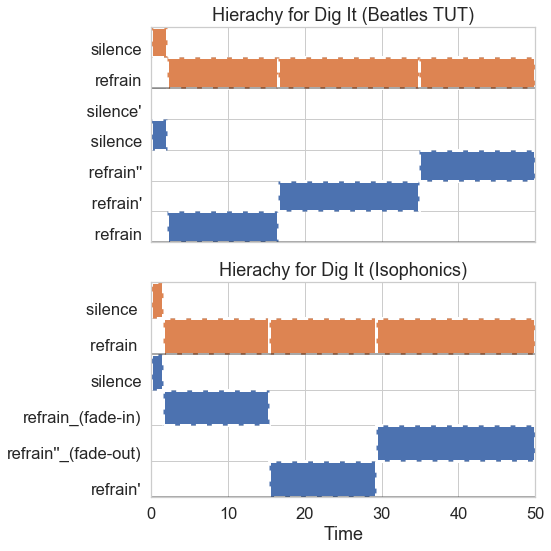

In [51]:
fig, (ax1, ax2) = plt.subplots(figsize=(8, 8), sharex=True, nrows=2)
jams.display.display(exp_T, meta=False, linewidth=3, linestyle='--', ax=ax1)
ax1.set(title='Hierachy for Dig It (Beatles TUT)')
ax1.label_outer()
jams.display.display(exp_I, meta=False, linewidth=3, linestyle='--', ax=ax2)
ax2.set(xlabel='Time', title='Hierachy for Dig It (Isophonics)')
plt.tight_layout();
fig.savefig('digit_exp.pdf', format='pdf', transparent=True, pad_inches=0.1)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


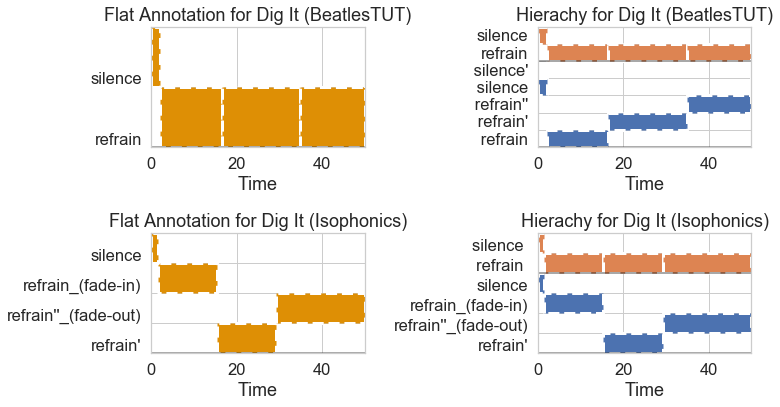

In [52]:
fig = plt.figure(figsize=(11, 6))
ax = plt.subplot(2,2,1)
jams.display.display(T.annotations['segment',0], meta=False, linewidth=3, facecolor=current_palette[1], linestyle='--')
plt.title('Flat Annotation for Dig It (BeatlesTUT)')
plt.xlabel('Time')
plt.subplot(2,2,2, sharex=ax)
jams.display.display(exp_T, meta=False, linewidth=3,  linestyle='--')
plt.xlabel('Time')
plt.title('Hierachy for Dig It (BeatlesTUT)');

ax = plt.subplot(2,2,3)
jams.display.display(I.annotations['segment',0], meta=False, linewidth=3, facecolor=current_palette[1], linestyle='--')
plt.title('Flat Annotation for Dig It (Isophonics)')
plt.xlabel('Time')
plt.subplot(2,2,4, sharex=ax)
jams.display.display(exp_I, meta=False, linewidth=3,  linestyle='--')
plt.xlabel('Time')
plt.title('Hierachy for Dig It (Isophonics)');
plt.tight_layout();
fig.savefig('digit_exp.pdf', format='pdf', transparent=True, pad_inches=0.1, frameon=False)

In [53]:
dirName = "/Users/kkinnaird/Documents/Research/R-Music/Brian-AHE/jams-data/datasets/"
fname = "07_-_Michelle.jams"
tut_jam = dirName + "BeatlesTUT/" + fname

inds = Tjamses.index(fname)
iso_jam = dirName + "Isophonics/The Beatles/" + Ijamses[inds]

T = jams.load(tut_jam)
I = jams.load(iso_jam)

(<Figure size 576x576 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x1c1cff7198>])

//anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
//anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


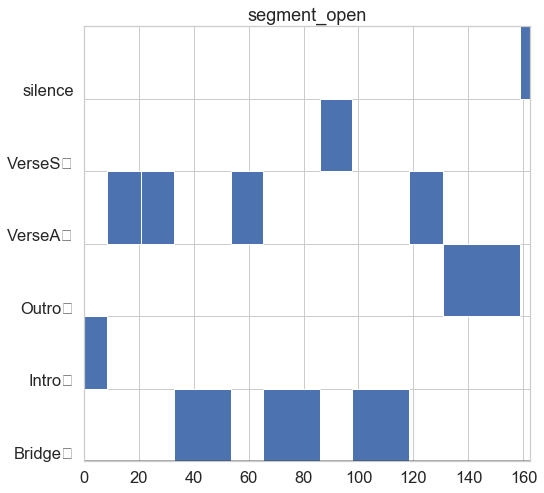

In [54]:
jams.display.display_multi(T.annotations['segment'], meta=False,
                           fig_kw=dict(figsize=(8,8)))

(<Figure size 576x576 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x1c1d923358>])

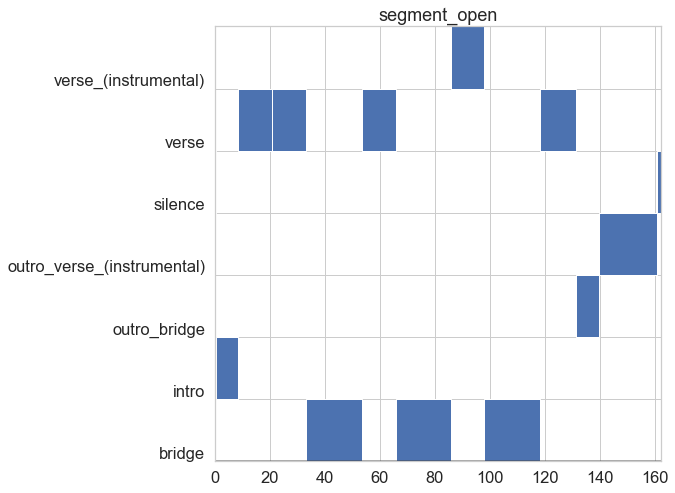

In [55]:
jams.display.display_multi(I.annotations['segment'], meta=False,
                           fig_kw=dict(figsize=(8,8)))

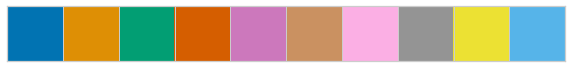

In [56]:
current_palette = sns.color_palette('colorblind')
sns.palplot(current_palette)
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

//anaconda3/lib/python3.7/site-packages/matplotlib/backends/_backend_pdf_ps.py:62: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
//anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:2001: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
//anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)
//anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)


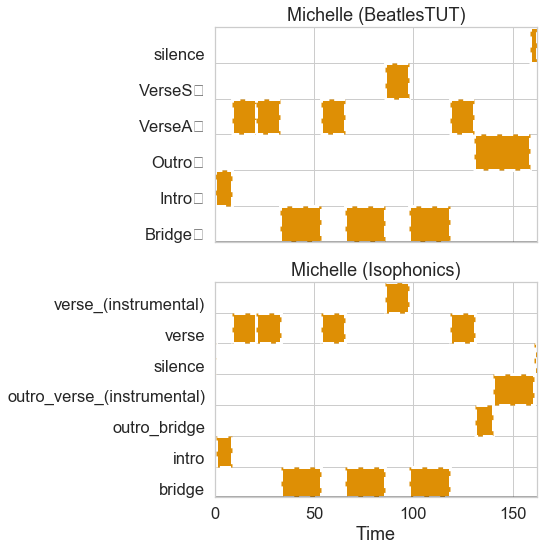

In [57]:
fig, (ax1, ax2) = plt.subplots(figsize=(8, 8), sharex=True, nrows=2)
jams.display.display(T.annotations['segment',0], meta=False, linewidth=3, facecolor=current_palette[1], linestyle='--', ax=ax1)
ax1.set(title='Michelle (BeatlesTUT)')
ax1.label_outer()
jams.display.display(I.annotations['segment',0], meta=False, linewidth=3, facecolor=current_palette[1], linestyle='--', ax=ax2)
ax2.set(xlabel='Time', title='Michelle (Isophonics)')
plt.tight_layout();
fig.savefig('michelle.pdf', format='pdf', transparent=True, pad_inches=0.1)

In [58]:
T_h = flat_to_hier(T.annotations['segment',0])

exp_T = expand_hierarchy(T_h, "TUT", full=True)


I_h = flat_to_hier(I.annotations['segment',0])

exp_I = expand_hierarchy(I_h, "I", full=True)

In [59]:
exp_I


<Annotation(namespace='multi_segment',
            time=0,
            duration=None,
            annotation_metadata=<AnnotationMetadata(...)>,
            data=<39 observations>,
            sandbox=<Sandbox(...)>)>

In [60]:
exp_T

<Annotation(namespace='multi_segment',
            time=0,
            duration=None,
            annotation_metadata=<AnnotationMetadata(...)>,
            data=<33 observations>,
            sandbox=<Sandbox(...)>)>

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
//anaconda3/lib/python3.7/site-packages/matplotlib/backends/_backend_pdf_ps.py:62: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
//anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py:2001: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
//anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
//anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


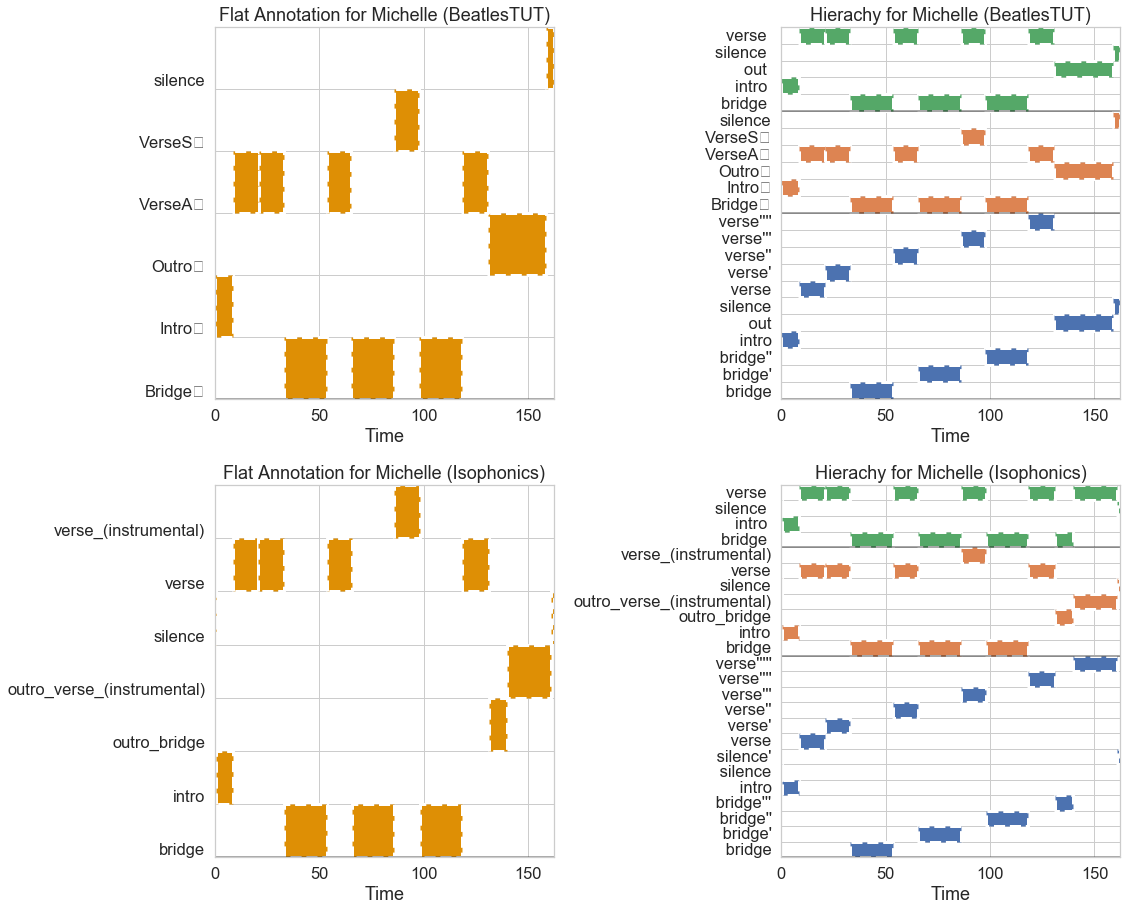

In [61]:
fig = plt.figure(figsize=(16, 13))
ax = plt.subplot(2,2,1)
jams.display.display(T.annotations['segment',0], meta=False, linewidth=3, facecolor=current_palette[1], linestyle='--')
plt.title('Flat Annotation for Michelle (BeatlesTUT)')
plt.xlabel('Time')
plt.subplot(2,2,2, sharex=ax)
jams.display.display(exp_T, meta=False, linewidth=3,  linestyle='--')
plt.xlabel('Time')
plt.title('Hierachy for Michelle (BeatlesTUT)');

ax = plt.subplot(2,2,3)
jams.display.display(I.annotations['segment',0], meta=False, linewidth=3, facecolor=current_palette[1], linestyle='--')
plt.title('Flat Annotation for Michelle (Isophonics)')
plt.xlabel('Time')
plt.subplot(2,2,4, sharex=ax)
jams.display.display(exp_I, meta=False, linewidth=3,  linestyle='--')
plt.xlabel('Time')
plt.title('Hierachy for Michelle (Isophonics)');
plt.tight_layout();
fig.savefig('michelle_exp.pdf', format='pdf', transparent=True, pad_inches=0.1, frameon=False)